In [17]:
import numpy as np
from preprocessing import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

In [3]:
def N(t_scalar, t):
    """
    Returns the number of times in t less than or equal to t_scalar.
    Is used to compute N(t_{i,k}) and N'(t_{i,k}) depending on whether t above is t or t_prime
    """

    return np.searchsorted(t, t_scalar, side="right")

def compensator_m3(t_scalar, t_prime, lambda_i, alpha_i, beta_i):
    """
    t_scalar: scalar value where Lambda_i(t) is to be evaluated
    t_prime: list of arrival times at station i

    NOTE: t_prime NEEDS TO BE SORTED HERE.
    """

    term1 = lambda_i * t_scalar
    term2 = -(alpha_i / beta_i) * np.sum(np.exp(-beta_i * (t_scalar - t_prime[:N(t_scalar, t_prime)]))-1)
    return term1 + term2


In [4]:
def getTimeDifferences(t, t_prime):
    """
    Input: (sorted) times for a particular station i
    Output: List of differences indexed by [h][k] for this station i
    """

    # h goes until N(t[-1], t) assuming T = t[-1]
    T = t[-1]
    D_result = []
    for h in range(1, N(T, t)+1):
        differences_list = []
        # Construct list of t_ih - t'_ik for k = 1 to N'(T)
        differences_list.append(t[h-1] - t_prime[N(t[h-2], t_prime):N(t[h-1], t_prime)])

        D_result.append(np.array(differences_list))

    return D_result

In [5]:
def new_B(h, t, t_prime, beta, time_differences):

    """
    Returns a list of [B_i(1), ..., B_i(h)]

    NOTE: t_prime NEEDS to be sorted here

    time_differences: time differences double list for station i

    Note all index variables such as h, k, etc start at 1, like the mathematical notation.
    """
    B = [np.sum(np.exp(-beta*(t[0] - t_prime[:N(t[0], t_prime)])))]

    # Append the rest
    for l in range(2, h+1):
        # First term in recursive formula for B_i(h)
        term1 = np.exp(-beta*(t[l-1] - t[l-2])) * B[l-2]
        term2 = np.sum(np.exp(-beta*(time_differences[l-1])))
        B.append(term1 + term2)
    return np.array(B)

def new_m3_log_likelihood(t, t_prime, alpha_i, beta_i, lambda_i, time_differences):
    """
    Gives log likelihood of our three parameters. 
    t: start times from station i
    t_prime: end times at station i

    NOTE: t_prime NEEDS TO BE SORTED HERE
    """
    
    T = t[-1] # TODO: Is this how we get big T? Yes

    # Get B list 
    B_ = new_B(len(t), t, t_prime, beta_i, time_differences)

    #term1 = np.sum(np.log(lambda_i + alpha_i*B_))
    term1 = np.sum(np.log(lambda_i + alpha_i*B_[:len(t)+1]))

    term2 = -compensator_m3(T, t_prime, lambda_i, alpha_i, beta_i)

    return term1 + term2


In [ ]:
sorted_start_ids = np.sort(bike_data.start_id.unique())

## Finding the parameters using likelihood optimisation

In [6]:
time_diffs = {}
for st_id in tqdm(train_sorted_start_ids):
    t = t_per_station[st_id]
    t_prime = t_prime_per_station[st_id] # Need to sort t_prime for likelihood function
    time_diffs[st_id] = getTimeDifferences(t, t_prime)

100%|██████████| 789/789 [00:13<00:00, 58.71it/s]


In [6]:
optimal_parameters = {}
for st_id in tqdm(train_sorted_start_ids):
    x0 = [np.log(0.01), np.log(0.1), np.log(0.01)] # np.log(rates_dict[station.start_id.unique()[0]])]
    # TODO: What bounds should we use here?
    t = t_per_station[st_id]
    t_prime = t_prime_per_station[st_id] # Need to sort t_prime for likelihood function
    time_differences = time_diffs[st_id]

    op_m3_likelihood = lambda x: -new_m3_log_likelihood(t, t_prime, np.exp(x[0]), np.exp(x[0]) + np.exp(x[1]), np.exp(x[2]), time_differences)
    sol = op.minimize(op_m3_likelihood, x0, method="Nelder-Mead")

    #sol = op.minimize(op_m3_likelihood, x0, method="SLSQP")
    if sol.success:
        transformed_alpha = np.exp(sol.x[0])
        transformed_beta = np.exp(sol.x[1]) + np.exp(sol.x[0])
        transformed_lambda = np.exp(sol.x[2])
        max_params = [transformed_alpha, transformed_beta, transformed_lambda]
        optimal_parameters[st_id] = max_params
    else:
        raise OptimizationError(f"Failed to converge for station {st_id}.")
optimal_parameters

100%|██████████| 789/789 [38:29<00:00,  2.93s/it]  


{1: [0.02017890620022561, 0.03555311474848593, 0.0077050576596426265],
 2: [0.01527106498719482, 0.016036203205164815, 0.0012130061829343293],
 3: [0.0046444511665453565, 0.0046444511665453565, 3.779972580570567e-17],
 4: [0.009820202831830637, 0.023542866322901417, 0.009676464206847835],
 5: [0.01187576237503422, 0.012869061950248605, 0.0012589960047066843],
 6: [0.011428096766882213, 0.011664594402862903, 0.00017053264013165565],
 7: [0.017310375580923243, 0.028937427560711153, 0.010587637538785584],
 8: [0.02304022039999643, 0.04740934446016881, 0.030447241629246065],
 9: [0.01620305437454439, 0.0181589213419557, 0.002922641848174015],
 10: [0.010309069853640275, 0.011266917921688472, 0.002234722874322887],
 11: [0.01583788323508194, 0.016345675017367667, 0.0013015217931437813],
 12: [0.011054467771412554, 0.01116025643755237, 0.001332554946708301],
 13: [0.008548789883746235, 0.009859793798701022, 0.0023508018361824705],
 14: [0.01163418862975088, 0.04969903441465035, 0.06005992899

In [ ]:
# param_df = pd.DataFrame(optimal_parameters.values(), index=optimal_parameters.keys(), columns = ["alpha", "beta", "lambda"])
# param_df.head() 
# param_df.to_csv("../data/M3_train_params.csv")

## Assessing fit for model 3

In [7]:
m3_parameters = pd.read_csv("../data/M3_train_params.csv", index_col=0)
m3_parameters

,alpha,beta,lambda
1,0.020179,0.035553,7.705058e-03
2,0.015271,0.016036,1.213006e-03
3,0.004644,0.004644,3.779973e-17
4,0.009820,0.023543,9.676464e-03
5,0.011876,0.012869,1.258996e-03
...,...,...,...
836,0.014502,0.039605,1.707352e-02
838,0.006228,0.006470,4.663218e-04
839,0.023140,0.028994,8.233945e-03
840,0.018468,0.019006,2.030979e-04


In [8]:
m3_parameters.loc[1].to_numpy()

array([0.02017891, 0.03555311, 0.00770506])

In [9]:
compensated_times_dict = {}
for st_id in tqdm(train_sorted_start_ids):
    params = m3_parameters.loc[st_id].to_numpy()
    tprime = t_prime_per_station[st_id]
    time = t_per_station[st_id]
    comp_st = lambda x: compensator_m3(x, tprime, params[2], params[0], params[1])
    compensated_times_dict[st_id] = [comp_st(i) for i in time]
compensated_times_dict[1]

100%|██████████| 789/789 [00:48<00:00, 16.32it/s]


[3.2755678450096823,
 3.8388193628716967,
 5.100100924087162,
 5.13415278308688,
 5.728808454415293,
 6.023476332253604,
 8.20149954366816,
 8.52650001471815,
 10.879463703673814,
 10.929220357592854,
 12.427653268109125,
 14.295045700509192,
 14.646284568914936,
 14.653626819260602,
 15.41016272373866,
 15.486423574220986,
 15.559146682485613,
 15.569936449710486,
 15.603138173414344,
 15.908512141870524,
 16.2489675993525,
 17.25310839242294,
 17.317368347115277,
 17.435620741718388,
 17.89303741761939,
 23.972378616685617,
 24.572231799538827,
 25.24364347882885,
 25.270103674264465,
 25.405467375497714,
 25.427267805900655,
 25.91981196595156,
 26.31044801712337,
 26.538231260315072,
 26.66114367589686,
 26.676618101590414,
 26.97669181111487,
 28.27709679242873,
 30.87721129451719,
 30.909778297314265,
 30.91562853082423,
 30.967740510700953,
 31.272194103620635,
 32.14693396313109,
 32.16343646216811,
 32.82292390964459,
 32.86099536044067,
 33.79704072414562,
 34.14215428755032,

In [10]:
m3_p_values = {}

for st_id in tqdm(train_sorted_start_ids):
    rate = rates_dict_train[st_id]
    inter_arrival_times = np.diff(compensated_times_dict[st_id])
    inter_arrival_times = np.insert(inter_arrival_times,0,compensated_times_dict[st_id][0])
    station_p_values = np.exp(-inter_arrival_times)
    m3_p_values[st_id] = station_p_values

100%|██████████| 789/789 [00:00<00:00, 7985.33it/s]


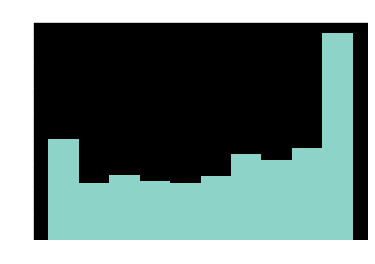

In [11]:
plt.title("Histogram of p-values for station 1 using Model 3")
plt.hist(m3_p_values[1])
plt.show()

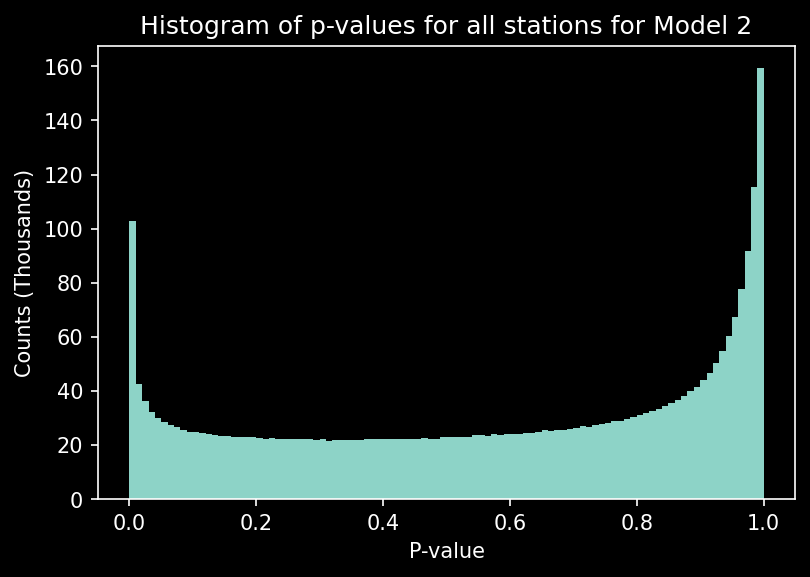

In [18]:
joined_p_values = np.concatenate(np.array(list(m3_p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations for Model 2")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values_m3.png")
plt.show()

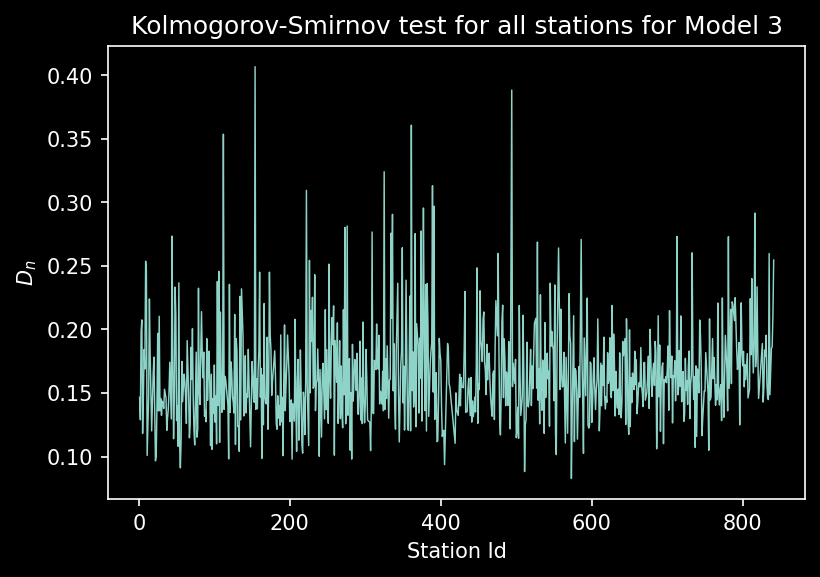

In [19]:
kol_smir_test = {}
for station_id, pvals in m3_p_values.items():
    kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test.keys(), kol_smir_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations for Model 3")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir_m3.png")
plt.show()

In [20]:
ks_df = pd.DataFrame(kol_smir_test.values(), index=kol_smir_test.keys(), columns = ["ks"])
ks_df.head()
outlier_ids = ks_df[ks_df.ks > 0.5].index.to_numpy()
print(outlier_ids)
for id in outlier_ids:
    print(optimal_parameters[id])

[]


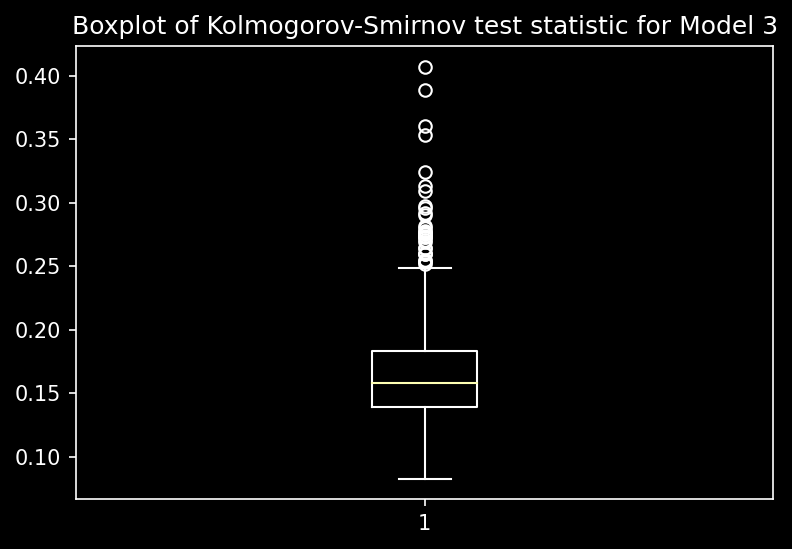

In [21]:
plt.boxplot(kol_smir_test.values())
plt.title("Boxplot of Kolmogorov-Smirnov test statistic for Model 3")
plt.show()

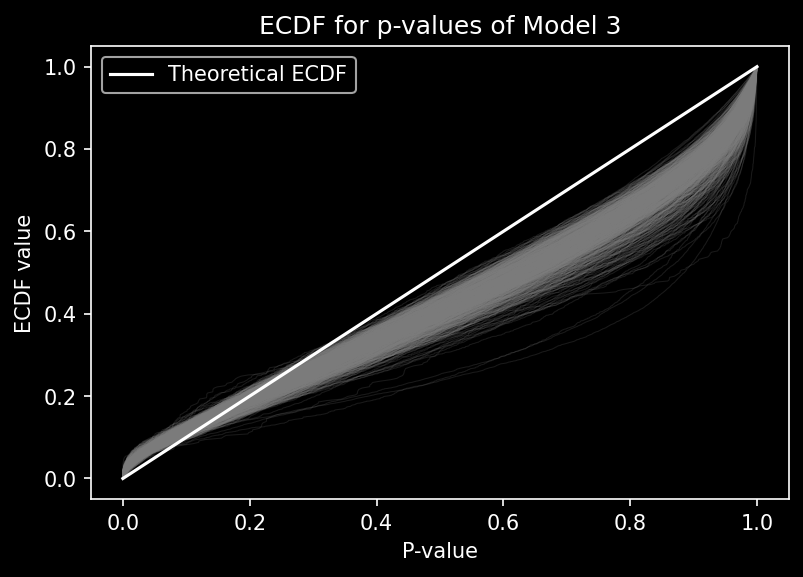

In [22]:
for station, pvals in m3_p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()